<a href="https://colab.research.google.com/github/Danazzz/dataset-beras-scm/blob/main/SCM_Beras1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
# Import libraries
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
plt.rcParams['figure.figsize'] = 15, 6            #agar semua plot ukurannya sama
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.vector_ar.var_model import VAR

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os

import xgboost

In [99]:
#Load data BI
converters = {
    'Beras': lambda x: str(x.replace(',', '')),
    'Beras Kualitas Bawah I' : lambda x: str(x.replace(',', '')),
    'Beras Kualitas Medium I' : lambda x: str(x.replace(',', '')),
    'Beras Kualitas Super I' : lambda x: str(x.replace(',', '')),
}

df1 = pd.read_csv('./csv/Tabel Harga Berdasarkan Daerah Jabar.csv', converters=converters)
df1

,Komoditas,Beras,Beras Kualitas Bawah I,Beras Kualitas Bawah II,Beras Kualitas Medium I,Beras Kualitas Medium II,Beras Kualitas Super I,Beras Kualitas Super II,Beras Kualitas Bawah,Beras Kualitas Medium,Beras Kualitas Super
0,01/ 01/ 2020,-,-,-,-,-,-,-,0,0,0
1,02/ 01/ 2020,11150,10100,9500,11350,10850,12900,12100,9800,11100,12500
2,03/ 01/ 2020,11150,10100,9500,11350,10850,12900,12100,9800,11100,12500
3,06/ 01/ 2020,11150,10150,9550,11350,10850,12900,12100,9850,11100,12500
4,07/ 01/ 2020,11200,10200,9650,11400,10900,12950,12150,9925,11150,12550
...,...,...,...,...,...,...,...,...,...,...,...
1093,11/ 03/ 2024,15800,14950,14500,16050,15550,17250,16550,14725,15800,16900
1094,12/ 03/ 2024,15800,14950,14500,16050,15550,17250,16550,14725,15800,16900
1095,13/ 03/ 2024,15750,14900,14400,16000,15450,17200,16550,14650,15725,16875
1096,14/ 03/ 2024,15750,14900,14400,16000,15450,17200,16550,14650,15725,16875


In [100]:
print('Data Types:')
print(df1.dtypes)

Data Types:
Komoditas                   object
Beras                       object
Beras Kualitas Bawah I      object
Beras Kualitas Bawah II     object
Beras Kualitas Medium I     object
Beras Kualitas Medium II    object
Beras Kualitas Super I      object
Beras Kualitas Super II     object
Beras Kualitas Bawah        object
Beras Kualitas Medium       object
Beras Kualitas Super        object
dtype: object


In [101]:
#Mengubah tanggal menjadi index
con=df1['Komoditas']
df1['Komoditas'] = pd.to_datetime(df1['Komoditas'], format='%d/ %m/ %Y')
df1.set_index('Komoditas', inplace=True)
#check datatype of index
df1.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-06',
               '2020-01-07', '2020-01-08', '2020-01-09', '2020-01-10',
               '2020-01-13', '2020-01-14',
               ...
               '2024-03-04', '2024-03-05', '2024-03-06', '2024-03-07',
               '2024-03-08', '2024-03-11', '2024-03-12', '2024-03-13',
               '2024-03-14', '2024-03-15'],
              dtype='datetime64[ns]', name='Komoditas', length=1098, freq=None)

In [102]:
df1 = df1.iloc[:, [0, 7, 8, 9]]
df1

,Beras,Beras Kualitas Bawah,Beras Kualitas Medium,Beras Kualitas Super
Komoditas,,,,
2020-01-01,-,0,0,0
2020-01-02,11150,9800,11100,12500
2020-01-03,11150,9800,11100,12500
2020-01-06,11150,9850,11100,12500
2020-01-07,11200,9925,11150,12550
...,...,...,...,...
2024-03-11,15800,14725,15800,16900
2024-03-12,15800,14725,15800,16900
2024-03-13,15750,14650,15725,16875


In [103]:
# Mengubah - menjadi 0
df1.replace('-', np.nan, inplace=True)
df1.replace('#DIV/0!', np.nan, inplace=True)
df1

/var/folders/3s/37cdhq1x7fdcds5p4y_vnbp00000gn/T/ipykernel_13894/1513190452.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.replace('-', np.nan, inplace=True)
/var/folders/3s/37cdhq1x7fdcds5p4y_vnbp00000gn/T/ipykernel_13894/1513190452.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.replace('#DIV/0!', np.nan, inplace=True)


,Beras,Beras Kualitas Bawah,Beras Kualitas Medium,Beras Kualitas Super
Komoditas,,,,
2020-01-01,NaN,0,0,0
2020-01-02,11150,9800,11100,12500
2020-01-03,11150,9800,11100,12500
2020-01-06,11150,9850,11100,12500
2020-01-07,11200,9925,11150,12550
...,...,...,...,...
2024-03-11,15800,14725,15800,16900
2024-03-12,15800,14725,15800,16900
2024-03-13,15750,14650,15725,16875


In [104]:
df1 = df1.astype('Int64')
df1

,Beras,Beras Kualitas Bawah,Beras Kualitas Medium,Beras Kualitas Super
Komoditas,,,,
2020-01-01,<NA>,0,0,0
2020-01-02,11150,9800,11100,12500
2020-01-03,11150,9800,11100,12500
2020-01-06,11150,9850,11100,12500
2020-01-07,11200,9925,11150,12550
...,...,...,...,...
2024-03-11,15800,14725,15800,16900
2024-03-12,15800,14725,15800,16900
2024-03-13,15750,14650,15725,16875


In [105]:
df1.info()
df1.shape

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1098 entries, 2020-01-01 to 2024-03-15
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Beras                  1050 non-null   Int64
 1   Beras Kualitas Bawah   1051 non-null   Int64
 2   Beras Kualitas Medium  1051 non-null   Int64
 3   Beras Kualitas Super   1051 non-null   Int64
dtypes: Int64(4)
memory usage: 47.2 KB


(1098, 4)

In [106]:
converters = {
    'Luas Panen Padi': lambda x: str(x.replace('.', '')),
    'GKP Tingkat Petani': lambda x: str(x.replace('.', '')),
    'GKP Tingkat Penggilingan' : lambda x: str(x.replace('.', '')),
    'GKG Tingkat Penggilingan' : lambda x: str(x.replace('.', '')),
    'Beras Medium Penggilingan' : lambda x: str(x.replace('.', '')),
    'Beras Premium Penggilingan' : lambda x: str(x.replace('.', '')),
}

#Load data
df2 = pd.read_csv('./csv/export-produsen-2.csv', converters=converters)
# print(df2.head())
df2

,Komoditas,Luas Panen Padi,GKP Tingkat Petani,GKP Tingkat Penggilingan,GKG Tingkat Penggilingan,Beras Medium Penggilingan,Beras Premium Penggilingan,Ratarata Beras Penggilingan,Jagung Pipilan Kering,Kedelai Biji Kering (Lokal),Bawang Merah,Cabai Merah Keriting,Cabai Rawit Merah,Sapi (Hidup),Ayam Ras Pedaging (Hidup),Telur Ayam Ras,Stok GKG Tingkat Penggilingan,Stok Beras Tingkat Penggilingan
0,01/01/2020,20,3700,4000,4500,8200,9200,8700,-,-,-,-,-,-,-,-,600,150
1,02/01/2020,-,-,-,-,-,-,#DIV/0!,-,-,-,-,-,-,-,-,-,-
2,03/01/2020,-,-,-,-,-,-,#DIV/0!,-,-,-,-,-,-,-,-,-,-
3,04/01/2020,-,-,-,-,-,-,#DIV/0!,-,-,-,-,-,-,-,-,-,-
4,05/01/2020,-,-,-,-,-,-,#DIV/0!,-,-,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,11/03/2024,10,6760,7140,8330,14180,15640,14910,5540,10610,15990,41880,45050,54440,24480,27540,120,80
1532,12/03/2024,10,6530,6930,8260,14140,15480,14810,5250,10610,16330,42830,43390,54470,24480,28260,120,80
1533,13/03/2024,10,6480,6920,8240,14040,15460,14750,5280,10310,15990,43770,42270,54560,24000,28200,100,60
1534,14/03/2024,10,6510,7060,8240,14050,15510,14780,5280,10310,15840,45070,41840,54550,24010,28130,150,70


PRODUSEN
Panel Harga Pangan pada tingkat produsen yang diamati meliputi:
- Luas Lahan/Sawah Padi, persentase (%) luas panen Padi di kecamatan sentra produksi.
- GKP Tingkat Petani, harga di Petani (Rp/Kg)
- GKP Tingkat Penggilingan, harga di Penggilingan (Rp/Kg)
- GKG Tingkat Penggilingan, harga di Penggilingan (Rp/Kg)
- Beras Medium Tingkat Penggilingan, harga di Penggilingan (Rp/Kg)
- Beras Premium Tingkat Penggilingan, harga di Penggilingan (Rp/Kg)
- Stok GKG Tingkat Penggilingan, stok dalam satuan Kwintal
- Stok Beras Tingkat Penggilingan, stok dalam satuan Kwintal

In [107]:
print('Data Types:')
print(df2.dtypes)

Data Types:
Komoditas                          object
Luas Panen Padi                    object
GKP Tingkat Petani                 object
GKP Tingkat Penggilingan           object
GKG Tingkat Penggilingan           object
Beras Medium Penggilingan          object
Beras Premium Penggilingan         object
Ratarata Beras Penggilingan        object
Jagung Pipilan Kering              object
Kedelai Biji Kering (Lokal)        object
Bawang Merah                       object
Cabai Merah Keriting               object
Cabai Rawit Merah                  object
Sapi (Hidup)                       object
Ayam Ras Pedaging (Hidup)          object
Telur Ayam Ras                     object
Stok GKG Tingkat Penggilingan      object
Stok Beras Tingkat Penggilingan    object
dtype: object


In [108]:
#Mengubah tanggal menjadi index
con=df2['Komoditas']
df2['Komoditas'] = pd.to_datetime(df2['Komoditas'], format='%d/%m/%Y')
df2.set_index('Komoditas', inplace=True)
#check datatype of index
df2.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2024-03-06', '2024-03-07', '2024-03-08', '2024-03-09',
               '2024-03-10', '2024-03-11', '2024-03-12', '2024-03-13',
               '2024-03-14', '2024-03-15'],
              dtype='datetime64[ns]', name='Komoditas', length=1536, freq=None)

In [109]:
print(df2.columns)

Index(['Luas Panen Padi', 'GKP Tingkat Petani', 'GKP Tingkat Penggilingan',
       'GKG Tingkat Penggilingan', 'Beras Medium Penggilingan',
       'Beras Premium Penggilingan', 'Ratarata Beras Penggilingan',
       'Jagung Pipilan Kering', 'Kedelai Biji Kering (Lokal)', 'Bawang Merah',
       'Cabai Merah Keriting', 'Cabai Rawit Merah', 'Sapi (Hidup)',
       'Ayam Ras Pedaging (Hidup)', 'Telur Ayam Ras',
       'Stok GKG Tingkat Penggilingan', 'Stok Beras Tingkat Penggilingan'],
      dtype='object')


In [110]:
df2 = df2.iloc[:, [0, 1, 2, 3, 6, 15, 16]]
df2

,Luas Panen Padi,GKP Tingkat Petani,GKP Tingkat Penggilingan,GKG Tingkat Penggilingan,Ratarata Beras Penggilingan,Stok GKG Tingkat Penggilingan,Stok Beras Tingkat Penggilingan
Komoditas,,,,,,,
2020-01-01,20,3700,4000,4500,8700,600,150
2020-01-02,-,-,-,-,#DIV/0!,-,-
2020-01-03,-,-,-,-,#DIV/0!,-,-
2020-01-04,-,-,-,-,#DIV/0!,-,-
2020-01-05,-,-,-,-,#DIV/0!,-,-
...,...,...,...,...,...,...,...
2024-03-11,10,6760,7140,8330,14910,120,80
2024-03-12,10,6530,6930,8260,14810,120,80
2024-03-13,10,6480,6920,8240,14750,100,60


In [111]:
# Mengubah - menjadi 0
df2.replace('-', np.nan, inplace=True)
df2.replace('#DIV/0!', np.nan, inplace=True)
df2

/var/folders/3s/37cdhq1x7fdcds5p4y_vnbp00000gn/T/ipykernel_13894/1801948625.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.replace('-', np.nan, inplace=True)
/var/folders/3s/37cdhq1x7fdcds5p4y_vnbp00000gn/T/ipykernel_13894/1801948625.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.replace('#DIV/0!', np.nan, inplace=True)


,Luas Panen Padi,GKP Tingkat Petani,GKP Tingkat Penggilingan,GKG Tingkat Penggilingan,Ratarata Beras Penggilingan,Stok GKG Tingkat Penggilingan,Stok Beras Tingkat Penggilingan
Komoditas,,,,,,,
2020-01-01,20,3700,4000,4500,8700,600,150
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2024-03-11,10,6760,7140,8330,14910,120,80
2024-03-12,10,6530,6930,8260,14810,120,80
2024-03-13,10,6480,6920,8240,14750,100,60


In [112]:
# ini datanya ada yang gajelas 1
# luas panen 20710?
df2 = df2.drop(df2[df2['Luas Panen Padi'] == '20710'].index)

In [113]:
df2 = df2.astype('Int64')
df2

,Luas Panen Padi,GKP Tingkat Petani,GKP Tingkat Penggilingan,GKG Tingkat Penggilingan,Ratarata Beras Penggilingan,Stok GKG Tingkat Penggilingan,Stok Beras Tingkat Penggilingan
Komoditas,,,,,,,
2020-01-01,20,3700,4000,4500,8700,600,150
2020-01-02,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2020-01-03,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2020-01-04,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2020-01-05,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...
2024-03-11,10,6760,7140,8330,14910,120,80
2024-03-12,10,6530,6930,8260,14810,120,80
2024-03-13,10,6480,6920,8240,14750,100,60


In [114]:
df2.info()
df2.shape

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1535 entries, 2020-01-01 to 2024-03-15
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   Luas Panen Padi                  1072 non-null   Int64
 1   GKP Tingkat Petani               1073 non-null   Int64
 2   GKP Tingkat Penggilingan         1073 non-null   Int64
 3   GKG Tingkat Penggilingan         1075 non-null   Int64
 4   Ratarata Beras Penggilingan      1075 non-null   Int64
 5   Stok GKG Tingkat Penggilingan    1063 non-null   Int64
 6   Stok Beras Tingkat Penggilingan  1063 non-null   Int64
dtypes: Int64(7)
memory usage: 106.4 KB


(1535, 7)

In [115]:
df3 = pd.merge(df2, df1, on='Komoditas', how='left')
df3

,Luas Panen Padi,GKP Tingkat Petani,GKP Tingkat Penggilingan,GKG Tingkat Penggilingan,Ratarata Beras Penggilingan,Stok GKG Tingkat Penggilingan,Stok Beras Tingkat Penggilingan,Beras,Beras Kualitas Bawah,Beras Kualitas Medium,Beras Kualitas Super
Komoditas,,,,,,,,,,,
2020-01-01,20,3700,4000,4500,8700,600,150,<NA>,0,0,0
2020-01-02,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,11150,9800,11100,12500
2020-01-03,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,11150,9800,11100,12500
2020-01-04,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2020-01-05,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...
2024-03-11,10,6760,7140,8330,14910,120,80,15800,14725,15800,16900
2024-03-12,10,6530,6930,8260,14810,120,80,15800,14725,15800,16900
2024-03-13,10,6480,6920,8240,14750,100,60,15750,14650,15725,16875


In [116]:
df3.info()
df3.nunique()

# Menampilkan nilai unik dalam setiap kolom
for col in df3.columns:
    unique_values = df3[col].unique()
    print(f"Nilai unik dalam kolom {col}: {unique_values}")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1535 entries, 2020-01-01 to 2024-03-15
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   Luas Panen Padi                  1072 non-null   Int64
 1   GKP Tingkat Petani               1073 non-null   Int64
 2   GKP Tingkat Penggilingan         1073 non-null   Int64
 3   GKG Tingkat Penggilingan         1075 non-null   Int64
 4   Ratarata Beras Penggilingan      1075 non-null   Int64
 5   Stok GKG Tingkat Penggilingan    1063 non-null   Int64
 6   Stok Beras Tingkat Penggilingan  1063 non-null   Int64
 7   Beras                            1049 non-null   Int64
 8   Beras Kualitas Bawah             1050 non-null   Int64
 9   Beras Kualitas Medium            1050 non-null   Int64
 10  Beras Kualitas Super             1050 non-null   Int64
dtypes: Int64(11)
memory usage: 160.4 KB
Nilai unik dalam kolom Luas Panen Padi: <IntegerArray>

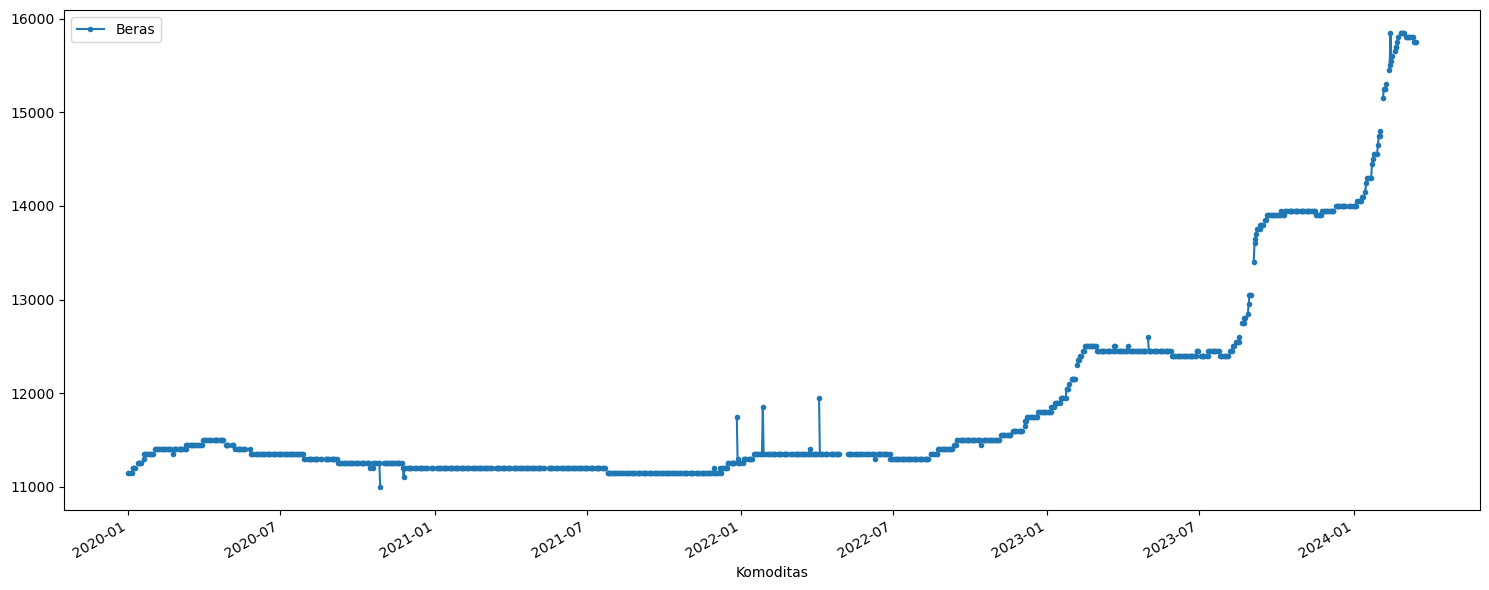

In [117]:
# plt.plot(df3)
df3[['Beras']].plot(style='.-', use_index=True)
# df3[['GKP Tingkat Petani']].loc['2020-01-01':'2024-03-01'].plot(style='.-')
plt.tight_layout()
plt.show()

In [118]:
# Clean dataset df3 from NaN
df3 = df3.dropna()
df3

,Luas Panen Padi,GKP Tingkat Petani,GKP Tingkat Penggilingan,GKG Tingkat Penggilingan,Ratarata Beras Penggilingan,Stok GKG Tingkat Penggilingan,Stok Beras Tingkat Penggilingan,Beras,Beras Kualitas Bawah,Beras Kualitas Medium,Beras Kualitas Super
Komoditas,,,,,,,,,,,
2021-03-15,10,4000,4150,5050,9465,20,10,11200,9800,11150,12650
2021-03-16,10,3850,4100,4740,9360,70,20,11200,9800,11150,12650
2021-03-17,10,4160,4230,4950,9400,30,10,11200,9800,11150,12650
2021-03-18,10,4120,4190,4730,9340,40,10,11200,9775,11175,12650
2021-03-19,10,4190,4290,4990,9410,40,10,11200,9800,11150,12650
...,...,...,...,...,...,...,...,...,...,...,...
2024-03-11,10,6760,7140,8330,14910,120,80,15800,14725,15800,16900
2024-03-12,10,6530,6930,8260,14810,120,80,15800,14725,15800,16900
2024-03-13,10,6480,6920,8240,14750,100,60,15750,14650,15725,16875


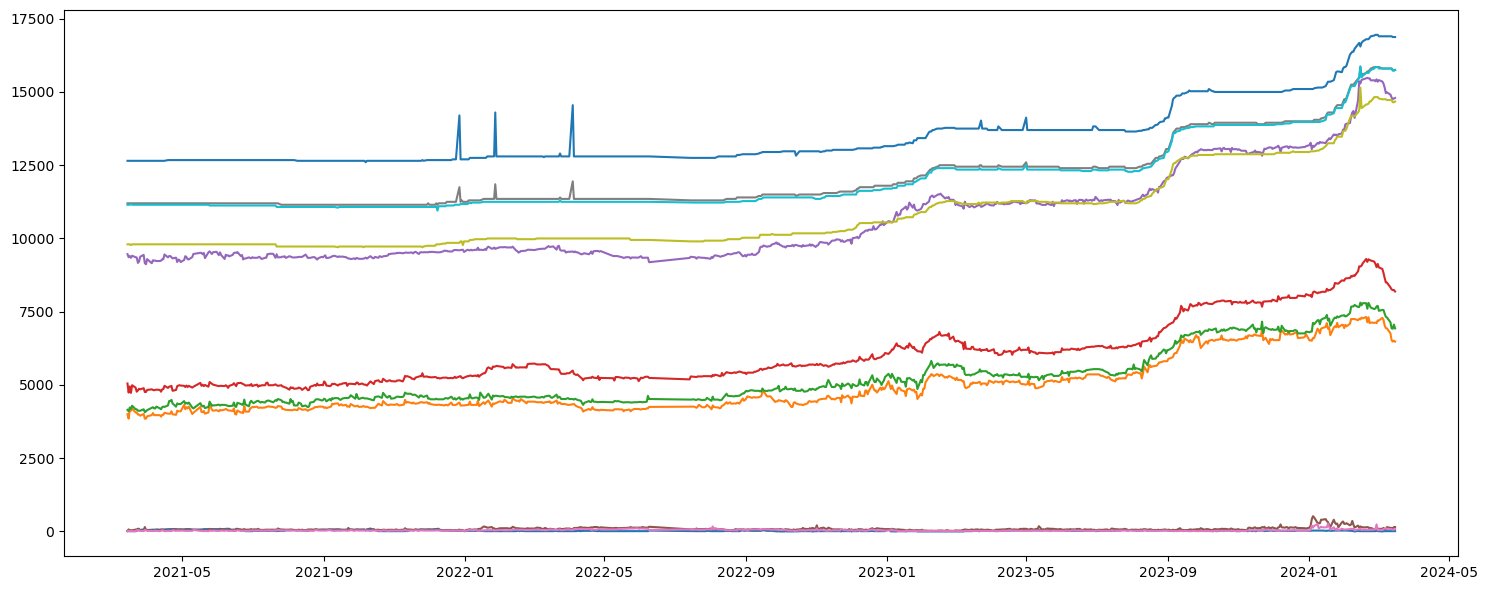

In [119]:
plt.plot(df3)
# df3[['GKP Tingkat Petani']].plot(style='.-', use_index=True)
# df3[['GKP Tingkat Petani']].loc['2020-01-01':'2024-03-01'].plot(style='.-')
plt.tight_layout()
plt.show()

Variabel dependen (variabel bergantung) = Harga Beras
Variabel Independen (variabel bebas) = Harga GKP, GKG

In [120]:
#is the dataset df3 ready for time series analysis?
df3.info()
df3.nunique()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 733 entries, 2021-03-15 to 2024-03-15
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   Luas Panen Padi                  733 non-null    Int64
 1   GKP Tingkat Petani               733 non-null    Int64
 2   GKP Tingkat Penggilingan         733 non-null    Int64
 3   GKG Tingkat Penggilingan         733 non-null    Int64
 4   Ratarata Beras Penggilingan      733 non-null    Int64
 5   Stok GKG Tingkat Penggilingan    733 non-null    Int64
 6   Stok Beras Tingkat Penggilingan  733 non-null    Int64
 7   Beras                            733 non-null    Int64
 8   Beras Kualitas Bawah             733 non-null    Int64
 9   Beras Kualitas Medium            733 non-null    Int64
 10  Beras Kualitas Super             733 non-null    Int64
dtypes: Int64(11)
memory usage: 76.6 KB


Luas Panen Padi                     11
GKP Tingkat Petani                 209
GKP Tingkat Penggilingan           226
GKG Tingkat Penggilingan           252
Ratarata Beras Penggilingan        332
Stok GKG Tingkat Penggilingan       37
Stok Beras Tingkat Penggilingan     20
Beras                               65
Beras Kualitas Bawah                96
Beras Kualitas Medium               83
Beras Kualitas Super                83
dtype: int64

In [121]:
df4 = pd.read_csv('./csv/distributor_pembelian.csv')
df4

,Komoditas,UMP,BBM Solar,quantity
0,01/01/2020,"1,810,351","9,500","113,151"
1,02/01/2020,"1,810,351","9,500","113,151"
2,03/01/2020,"1,810,351","9,500","113,151"
3,04/01/2020,"1,810,351","9,500","113,151"
4,05/01/2020,"1,810,351","9,500","113,151"
...,...,...,...,...
1531,11/03/2024,"2,057,495","6,800","113,151"
1532,12/03/2024,"2,057,495","6,800","113,151"
1533,13/03/2024,"2,057,495","6,800","113,151"
1534,14/03/2024,"2,057,495","6,800","113,151"


In [122]:
#delete all commas in the data
df4['UMP'] = df4['UMP'].str.replace(',', '')
df4['BBM Solar'] = df4['BBM Solar'].str.replace(',', '')
df4['quantity'] = df4['quantity'].str.replace(',', '')
df4

,Komoditas,UMP,BBM Solar,quantity
0,01/01/2020,1810351,9500,113151
1,02/01/2020,1810351,9500,113151
2,03/01/2020,1810351,9500,113151
3,04/01/2020,1810351,9500,113151
4,05/01/2020,1810351,9500,113151
...,...,...,...,...
1531,11/03/2024,2057495,6800,113151
1532,12/03/2024,2057495,6800,113151
1533,13/03/2024,2057495,6800,113151
1534,14/03/2024,2057495,6800,113151


In [123]:
#Mengubah tanggal menjadi index
con=df4['Komoditas']
df4['Komoditas'] = pd.to_datetime(df4['Komoditas'], format='%d/%m/%Y')
df4.set_index('Komoditas', inplace=True)
#check datatype of index
df4.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2024-03-06', '2024-03-07', '2024-03-08', '2024-03-09',
               '2024-03-10', '2024-03-11', '2024-03-12', '2024-03-13',
               '2024-03-14', '2024-03-15'],
              dtype='datetime64[ns]', name='Komoditas', length=1536, freq=None)

In [124]:
df4 = df4.astype('Int64')
df4

,UMP,BBM Solar,quantity
Komoditas,,,
2020-01-01,1810351,9500,113151
2020-01-02,1810351,9500,113151
2020-01-03,1810351,9500,113151
2020-01-04,1810351,9500,113151
2020-01-05,1810351,9500,113151
...,...,...,...
2024-03-11,2057495,6800,113151
2024-03-12,2057495,6800,113151
2024-03-13,2057495,6800,113151


In [125]:
df5 = pd.merge(df3, df4, on='Komoditas', how='left')
df5

,Luas Panen Padi,GKP Tingkat Petani,GKP Tingkat Penggilingan,GKG Tingkat Penggilingan,Ratarata Beras Penggilingan,Stok GKG Tingkat Penggilingan,Stok Beras Tingkat Penggilingan,Beras,Beras Kualitas Bawah,Beras Kualitas Medium,Beras Kualitas Super,UMP,BBM Solar,quantity
Komoditas,,,,,,,,,,,,,,
2021-03-15,10,4000,4150,5050,9465,20,10,11200,9800,11150,12650,1810351,9600,113151
2021-03-16,10,3850,4100,4740,9360,70,20,11200,9800,11150,12650,1810351,9600,113151
2021-03-17,10,4160,4230,4950,9400,30,10,11200,9800,11150,12650,1810351,9600,113151
2021-03-18,10,4120,4190,4730,9340,40,10,11200,9775,11175,12650,1810351,9600,113151
2021-03-19,10,4190,4290,4990,9410,40,10,11200,9800,11150,12650,1810351,9600,113151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-11,10,6760,7140,8330,14910,120,80,15800,14725,15800,16900,2057495,6800,113151
2024-03-12,10,6530,6930,8260,14810,120,80,15800,14725,15800,16900,2057495,6800,113151
2024-03-13,10,6480,6920,8240,14750,100,60,15750,14650,15725,16875,2057495,6800,113151


In [126]:
print(df5.dtypes)

Luas Panen Padi                    Int64
GKP Tingkat Petani                 Int64
GKP Tingkat Penggilingan           Int64
GKG Tingkat Penggilingan           Int64
Ratarata Beras Penggilingan        Int64
Stok GKG Tingkat Penggilingan      Int64
Stok Beras Tingkat Penggilingan    Int64
Beras                              Int64
Beras Kualitas Bawah               Int64
Beras Kualitas Medium              Int64
Beras Kualitas Super               Int64
UMP                                Int64
BBM Solar                          Int64
quantity                           Int64
dtype: object


In [127]:
df5 = df5.rename(columns={'Beras': 'y', 'Komoditas': 'ds'})
train = df5.loc[df5['ds'] < '2021-03-15']
valid = df5.loc[df5['ds'] >= '2021-03-15']
h = 4

KeyError: 'ds'

In [ ]:
# #use minmaxscaler to scale the data
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# df5_scaled = scaler.fit_transform(df5)
# df5_scaled = pd.DataFrame(df5_scaled, columns=df5.columns)
# df5_scaled


In [ ]:
# #z-score normalization
# from scipy.stats import zscore
# df5_zscore = df5.apply(zscore)
# df5_zscore

In [ ]:
from sklearn.preprocessing import StandardScaler

# Create a copy of df5
df5_scaled = df5.copy()

# Apply decimal scaling using StandardScaler
scaler = StandardScaler()
df5_scaled[df5.columns] = scaler.fit_transform(df5[df5.columns])

# Display the scaled DataFrame
df5_scaled


,Luas Panen Padi,GKP Tingkat Petani,GKP Tingkat Penggilingan,GKG Tingkat Penggilingan,Ratarata Beras Penggilingan,Stok GKG Tingkat Penggilingan,Stok Beras Tingkat Penggilingan,Beras,Beras Kualitas Bawah,Beras Kualitas Medium,Beras Kualitas Super,UMP,BBM Solar,quantity
Komoditas,,,,,,,,,,,,,,
2021-03-15,-0.750064,-1.033905,-1.127019,-0.907054,-0.775021,-1.123254,-1.018055,-0.783780,-0.800461,-0.745751,-0.792148,-1.022387,0.638494,0.0
2021-03-16,-0.750064,-1.193042,-1.178372,-1.183437,-0.841349,-0.247169,-0.676841,-0.783780,-0.800461,-0.745751,-0.792148,-1.022387,0.638494,0.0
2021-03-17,-0.750064,-0.864159,-1.044854,-0.996210,-0.816081,-0.948037,-1.018055,-0.783780,-0.800461,-0.745751,-0.792148,-1.022387,0.638494,0.0
2021-03-18,-0.750064,-0.906596,-1.085937,-1.192353,-0.853983,-0.772820,-1.018055,-0.783780,-0.819211,-0.725284,-0.792148,-1.022387,0.638494,0.0
2021-03-19,-0.750064,-0.832332,-0.983231,-0.960548,-0.809764,-0.772820,-1.018055,-0.783780,-0.800461,-0.745751,-0.792148,-1.022387,0.638494,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-11,-0.750064,1.894215,1.943888,2.017257,2.664563,0.628917,1.370441,3.020105,2.893252,3.061129,3.176237,1.791570,-0.779353,0.0
2024-03-12,-0.750064,1.650205,1.728206,1.954848,2.601393,0.628917,1.370441,3.020105,2.893252,3.061129,3.176237,1.791570,-0.779353,0.0
2024-03-13,-0.750064,1.597159,1.717935,1.937017,2.563491,0.278483,0.688013,2.978758,2.837002,2.999728,3.152893,1.791570,-0.779353,0.0


In [ ]:
#drop column Beras Kualitas Bawah I, Beras Kualitas Medium I, Beras Kualitas Super I
df5 = df5.drop(['Beras Kualitas Bawah', 'Beras Kualitas Medium', 'Beras Kualitas Super'], axis=1)

In [ ]:
import xgboost
import numpy as np

# List of features to predict
features = list(df5.columns)

# Dictionary to store models
models = {}

for feature in features:
    # Split the data into train and test sets
    train = df5[feature][:int(0.8*(len(df5)))]
    test = df5[feature][int(0.8*(len(df5))):]

    # Fit the XGBoost model
    model = xgboost.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(np.array(range(len(train))).reshape(-1, 1), train)

    # Store the model in the dictionary
    models[feature] = model

RMSE: 61.7182329873843


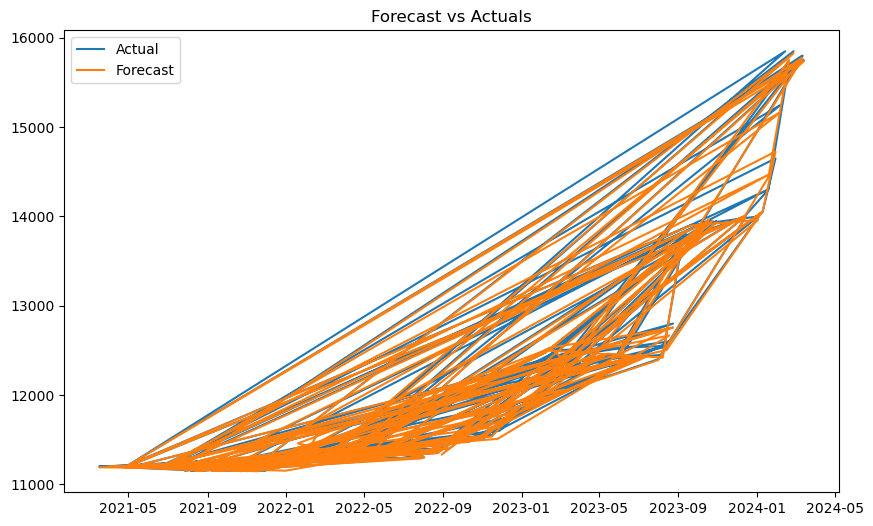

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'model' is your trained model and 'X_test' is your test features
# Forecast the future values

# Assuming 'df' is your original DataFrame and 'feature_cols' is a list of column names
X = df5.drop('Beras', axis=1) # This selects all columns except 'Beras'
y = df5['Beras']  # replace 'Beras' with your actual target column name

from sklearn.model_selection import train_test_split

# Assuming 'X' is your features and 'y' is your target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train your model on the training data
model.fit(X_train, y_train)

# Now you can use X_test
predictions = model.predict(X_test)

# Calculate the RMSE for each feature
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE: {rmse}')

# Plot the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, predictions, label='Forecast')
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()

# Dictionary to store the predictions
predictions_dict = {'forecast': predictions}

Feature: 0, Score: 0.00042
Feature: 1, Score: 0.08813
Feature: 2, Score: 0.05598
Feature: 3, Score: 0.30684
Feature: 4, Score: 0.21652
Feature: 5, Score: 0.00032
Feature: 6, Score: 0.00005
Feature: 7, Score: 0.32658
Feature: 8, Score: 0.00516
Feature: 9, Score: 0.00000


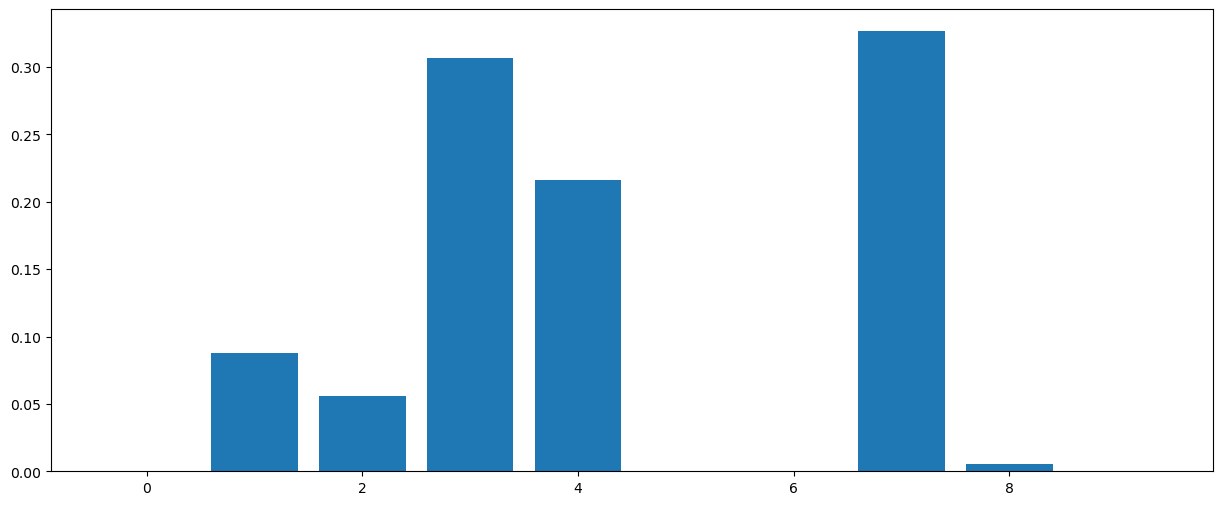

In [ ]:
# Assuming 'model' is your trained XGBoost model and 'X' is your feature DataFrame
importance = model.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [ ]:
#which one is feature 0, 1, 2, 3, 4, 5, 6, 7?
X.columns

Index(['Luas Panen Padi', 'GKP Tingkat Petani', 'GKP Tingkat Penggilingan',
       'GKG Tingkat Penggilingan', 'Ratarata Beras Penggilingan',
       'Stok GKG Tingkat Penggilingan', 'Stok Beras Tingkat Penggilingan',
       'UMP', 'BBM Solar', 'quantity'],
      dtype='object')

In [ ]:
# Assuming 'model' is your trained XGBoost model and 'X' is your feature DataFrame
importance = model.feature_importances_

# Create a pandas series with feature importances
importance_series = pd.Series(importance, index=X.columns)

# Sort the series in descending order
sorted_importances = importance_series.sort_values(ascending=False)

# Print the sorted series
print(sorted_importances)

UMP                                0.326579
GKG Tingkat Penggilingan           0.306836
Ratarata Beras Penggilingan        0.216516
GKP Tingkat Petani                 0.088134
GKP Tingkat Penggilingan           0.055977
BBM Solar                          0.005162
Luas Panen Padi                    0.000421
Stok GKG Tingkat Penggilingan      0.000323
Stok Beras Tingkat Penggilingan    0.000052
quantity                           0.000000
dtype: float32


In [ ]:
#predict the future values of the features
X_future = df5.drop('Beras', axis=1).tail(10)
predictions = model.predict(X_future)
predictions

array([15799.999, 15800.001, 15799.996, 15800.002, 15800.   , 15776.586,
       15771.261, 15750.001, 15739.039, 15749.999], dtype=float32)

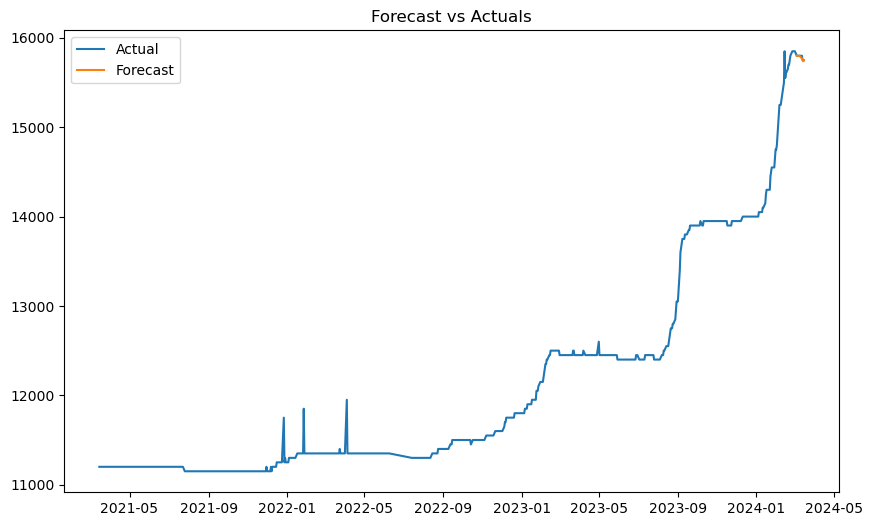

In [ ]:
#create a plot of the forecasted values (10 days into the future)
plt.figure(figsize=(10, 6))
plt.plot(df5['Beras'].index, df5['Beras'], label='Actual')
plt.plot(X_future.index, predictions, label='Forecast')
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()

In [ ]:
# Assuming 'model' is your trained XGBoost model and 'X' is your feature DataFrame
X_future_30_days = df5.drop('Beras', axis=1).tail(30)
predictions_30_days = model.predict(X_future_30_days)

# Create a date range for the next 30 days
date_range = pd.date_range(start=df5.index[-1], periods=30, freq='D')

# Create a DataFrame to store the predictions
predictions_df = pd.DataFrame({'Date': date_range, 'Beras': predictions_30_days})

# Set the 'Date' column as the index
predictions_df.set_index('Date', inplace=True)

# Display the predictions DataFrame
predictions_df


,Beras
Date,
2024-03-15,15150.000977
2024-03-16,15250.000977
2024-03-17,15170.092773
2024-03-18,15249.999023
2024-03-19,15300.000977
2024-03-20,15449.998047
2024-03-21,15500.000977
2024-03-22,15578.711914
2024-03-23,15550.001953
